
# **Seoul Bike Rental Data Prediction XGBoost - Extreme Gradient Boosting**


Why XG Boost?
*   Highly Flexible
*   Parrallel Processing
*   Supports Regularization
*   Ideal for small to Medium Dataset
*   **Able to run Cross Validation after each iteration**
*   **Availability of GPU Acceleration**

# **Import Required Packages**

In [ ]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions

from scipy.stats import uniform #for training and test splits
import statsmodels.api as smf #R-like model specification
import matplotlib.pyplot as plt #2D plotting
from google.colab import files
import io
import xgboost
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# **Initial Preprocessing and Data Exploration**

After preprocessing our data (seperate Py Notebook) set which included reformating the data we exported our data to a csv for more expident access.

Preprocessing included:
*   Converting string features to a "Category" data type
*   Addition of "Day of Year", "Week of Year" in order to add more granularity to our data.


In [ ]:
bikes = pd.read_csv('https://raw.githubusercontent.com/dudemandando/Data/main/bikeDataClean.csv')
del bikes['Unnamed: 0']
bikes['Seasons'] = bikes['Seasons'].astype('category')
bikes['Holiday'] = bikes['Holiday'].astype('category')
bikes['Functioning_Day'] = bikes['Functioning_Day'].astype('category')
bikes['Weekday'] = bikes['Weekday'].astype('category')
bikes.dtypes

Date                       object
Rented_Bike_Count           int64
Hour                        int64
Temperature               float64
Humidity                    int64
Wind_Speed                float64
Visibility                  int64
Dew_Point_Temperature     float64
Solar_Radiation           float64
Rainfall                  float64
Snowfall                  float64
Seasons                  category
Holiday                  category
Functioning_Day          category
Year                        int64
Month                       int64
Day                         int64
Weekday                  category
year                        int64
month                       int64
dayofweek                   int64
weekofyear                  int64
dtype: object

In [126]:
print("Minimum Bike Rental: ", bikes['Rented_Bike_Count'].min())
print("Minimum Bike Rental: ", bikes['Rented_Bike_Count'].max())

Minimum Bike Rental:  0
Minimum Bike Rental:  3556


# **Split Data (X,Y)**

Upon completion of our preprocessing, we now split our data into our dependant and independent variables.

Our target is to predict the Rented bike count for a given day with enviromental (weather) features. To do this we must create our x variable which does not contain the rented bike count nor date.

In [ ]:
x = bikes.drop(columns=['Rented_Bike_Count', 'Date'])
y = bikes.Rented_Bike_Count



# **Encode Categorical Data as Numrical**

Looking at our above console print out we see that we possess "category" columns (specifically **Holiday**, **Functioning** **Day**, **Seasons**, **Weekday**. In order to successfuly run and generater an gradient-boosted model we must convert these columns to a numerical value. We do this by instatiating the **"Label Encoder"** from the SKLearn library. 

**Note:** It is possible to encode this values by column (example below) should a user require more control and/or wish to view all categories generated. This may be more valuable in other datasets where categories may be excessive in size.
```
seasons_cat = bikes[['Seasons']]
holiday_cat = bikes[['Holiday']]
func_day_cat = bikes[['Functioning_Day']]
weekday_cat = bikes[['Weekday']]

seasons_encoder = OrdinalEncoder()

seasons_encoded = seasons_encoder.fit_transform(seasons_cat)
holiday_encoder = OrdinalEncoder()
holiday_encoded = holiday_encoder.fit_transform(holiday_cat)
func_day_encoder = OrdinalEncoder()
func_day_encoded = func_day_encoder.fit_transform(func_day_cat)
weekday_encoder = OrdinalEncoder()
weekday_encoded = weekday_encoder.fit_transform(weekday_cat)
```



In [ ]:

labelEncoder = LabelEncoder()
categ = ['Holiday', 'Functioning_Day', 'Seasons', 'Weekday']
x[categ] = x[categ].apply(labelEncoder.fit_transform)


# **Generate Test and Train Subgroups**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

# **Find Best Hyper Parameters - XGBoost Estimator**

To "*get our foot in the door*" with hyper parameters, we utilize the "XGBoost" Estimator to try out every combination of the "max_depth" and "n_estimators" hyper parameters.

**"n_estimators"** referes to the number of gradient boosted trees or the number of boosted rounds. 

**"max_depth"**refers to the maximum depth of a tree, increasing this value adds complexity to our model. 


In [ ]:
regressor = xgboost.XGBRegressor()

param_grid = {
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "n_estimators"        : [70, 75, 80]

 }

search = GridSearchCV(regressor, param_grid).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

In [ ]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'max_depth': 8, 'n_estimators': 80}


# **View Feature Importance**

In [133]:

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

xgb.feature_importances_

[22:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.08472744, 0.17232434, 0.09591668, 0.00441917, 0.00990766,
       0.05025389, 0.11363837, 0.1254775 , 0.00473923, 0.08607554,
       0.01017522, 0.19735777, 0.00224244, 0.00657116, 0.00739993,
       0.00500346, 0.        , 0.        , 0.01445114, 0.00931899],
      dtype=float32)

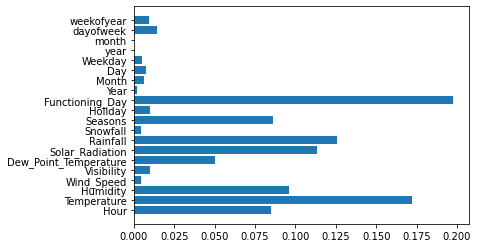

In [154]:
feature_names = bikes.columns[2:]
bp = plt.barh(feature_names, xgb.feature_importances_)

# **Initial Model**

Before tuning any parameters we'll first create a generic model to view 

In [ ]:
firstXGModel = make_pipeline(StandardScaler(), XGBRegressor(silent=1))
# Cross-validation
cv = cross_val_score(firstXGModel, X_train, y_train, cv=10)

print('Average R2', np.mean(cv))

Average R2 0.8437614158425433


Text(0, 0.5, 'Actual Bike Rentals')

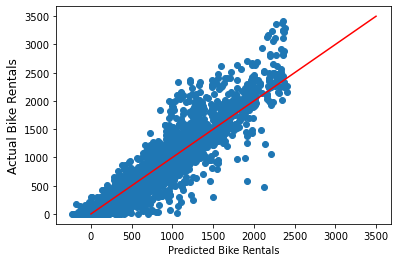

In [ ]:
firstXGModel.fit(X_train, y_train)
y_pred = firstXGModel.predict(X_test)

# 1:1 line
x = np.linspace(0,3500,10)
y = x

# Scatter plot predicted vs. actual
plt.scatter(y_pred, y_test)
plt.plot(x, y, c='r')

plt.xlabel('Predicted Bike Rentals', size=10)
plt.ylabel('Actual Bike Rentals', size=12)

# **Actual/Predicted Bike Rentals Visulization Explaination and Insights**

After plotting our generic XGBoost regression, immediatly it becomes apparent that there is a limit to the models ability to adequetly predict values above approixmatly 2500 (see below).



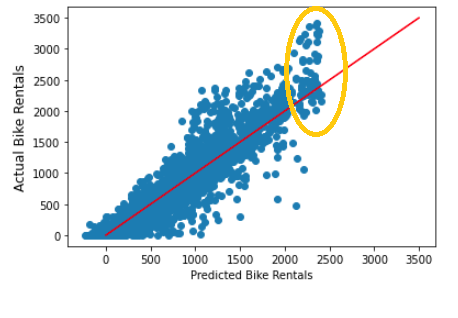

**Potential Cause:**
This "wall" we are hitting can most likley be attributed to the maximum depth of the tree; requiring us to pay most attention to this tuning hyper-parameter. 

# **Follow On Models With Tuning**
 
 Parameters: 
 n_estimators  "Number of gradient boosted trees. Equivalent to number 
                of boosting rounds."
 learning_rate "Boosting learning rate (also known as “eta”)"
 
 max_depth     "Maximum depth of a tree. Increasing this value will make 
                the model more complex and more likely to overfit." 


In [ ]:
secondXGModel = make_pipeline(StandardScaler(), XGBRegressor(silent=1, n_estimators=80, max_depth=8, eta=0.01,
                                                    subsample=0.6))

# Cross-validation
cv = cross_val_score(secondXGModel, X_train, y_train, cv=10)
print('Average R2', np.mean(cv))

Average R2 0.9212275514684801


In [ ]:
secondXGModel.fit(X_train, y_train)
y_pred = secondXGModel.predict(X_test)

Text(0, 0.5, 'Actual Bike Rentals')

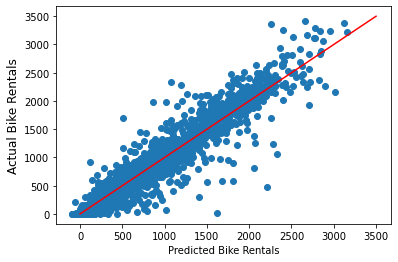

In [ ]:
x = np.linspace(0,3500,10)
y = x
plt.scatter(y_pred, y_test)
plt.plot(x, y, c='r')
plt.xlabel('Predicted Bike Rentals', size=10)
plt.ylabel('Actual Bike Rentals', size=12)

Average R2 0.9212947147659781


Text(0, 0.5, 'Actual Bike Rentals')

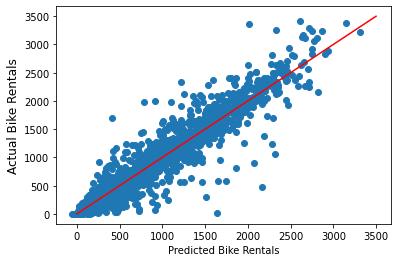

In [127]:
secondXGModel = make_pipeline(StandardScaler(), XGBRegressor(silent=1, n_estimators=82, max_depth=12, eta=0.01,
                                                    subsample=0.7))

cv = cross_val_score(secondXGModel, X_train, y_train, cv=10)
print('Average R2', np.mean(cv))

secondXGModel.fit(X_train, y_train)
y_pred = secondXGModel.predict(X_test)

x = np.linspace(0,3500,10)
y = x

plt.scatter(y_pred, y_test)
plt.plot(x, y, c='r')
plt.xlabel('Predicted Bike Rentals', size=10)
plt.ylabel('Actual Bike Rentals', size=12)

Average R2 0.9196727535069854


Text(0, 0.5, 'Actual Bike Rentals')

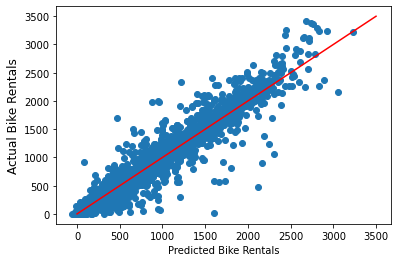

In [ ]:
secondXGModel = make_pipeline(StandardScaler(), XGBRegressor(silent=1, n_estimators=85, max_depth=12, eta=0.01,
                                                    subsample=0.55))


cv = cross_val_score(secondXGModel, X_train, y_train, cv=10)
print('Average R2', np.mean(cv))

secondXGModel.fit(X_train, y_train)
y_pred = secondXGModel.predict(X_test)
x = np.linspace(0,3500,10)
y = x
plt.scatter(y_pred, y_test)
plt.plot(x, y, c='r')
plt.xlabel('Predicted Bike Rentals', size=10)
plt.ylabel('Actual Bike Rentals', size=12)


In [ ]:
secondXGModel = make_pipeline(StandardScaler(), XGBRegressor(silent=1, n_estimators=60, max_depth=7, eta=0.01,
                                                    subsample=0.55, gamma=0.5))


cv = cross_val_score(secondXGModel, X_train, y_train, cv=10)
print('Average R2', np.mean(cv))

secondXGModel.fit(X_train, y_train)
y_pred = secondXGModel.predict(X_test)
x = np.linspace(0,3500,10)
y = x
plt.scatter(y_pred, y_test)
plt.plot(x, y, c='r')
plt.xlabel('Predicted Bike Rentals', size=10)
plt.ylabel('Actual Bike Rentals', size=12)